In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np

real = pd.read_parquet("results/dec7_optimized.parquet")

unique_families = real['mirna_family'].unique()
longest_family_name = max(unique_families, key=len)
real['mirna_family'] = real['mirna_family'].replace({longest_family_name: 'miR-548ay-5p_long'})


In [2]:
def plot_mutation_signatures(data, title, figsize=(12, 6)):
    """
    Create a bar plot of mutation signature distribution.
    
    Args:
        data: DataFrame containing mutation signature data
        figsize: Tuple specifying figure dimensions (width, height)
    """
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Create countplot with updated syntax
    ax = sns.countplot(
        x='mutsig',
        hue='mutsig',  # Add hue parameter
        data=data,
        order=data.mutsig.value_counts().index,
        palette='viridis',
        legend=False  # Hide legend since it's redundant
    )
    
    # Set titles and labels
    ax.set_title(title, 
                 fontsize=15, pad=20)
    ax.set_xlabel('Mutation Signature', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            f'{int(height)}',
            xy=(bar.get_x() + bar.get_width()/2., height),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    

def plot_stacked_mutation_signatures(df_tsupps, df_oncogenes, figsize=(12, 8)):

    # Prepare data
    df_tsupps['gene_type'] = 'Tumor Suppressors'
    df_oncogenes['gene_type'] = 'Oncogenes'
    df_combined = pd.concat([df_tsupps, df_oncogenes])
    
    # Get order of mutation signatures by total count
    order = df_combined['mutsig'].value_counts().index

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked bar plot
    sns.countplot(
        x='mutsig',
        hue='gene_type',
        data=df_combined,
        order=order,
        palette='viridis'
    )
    
    # Set titles and labels
    ax.set_title('Mutation Signature Distribution: Downregulated Tumor Suppressors vs Upregulated Oncogenes', 
                 fontsize=15, pad=20)
    ax.set_xlabel('Mutation Signature', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Alternative with more formatting options
    for container in ax.containers:
        ax.bar_label(container, 
                    label_type='center',
                    fontsize=8,
                    weight='light',  # Makes the font lighter
                    color='black')   # Changes text color

    # Adjust layout
    plt.legend(title='Gene Type', loc='upper right')
    plt.tight_layout()
    plt.show()


In [3]:
df = pd.read_csv("results/dec7_final_data.csv")
df.drop(columns=["upregulated_real", "downregulated_real", "upregulated_synth", "downregulated_synth", "p_value"], inplace=True)

# Filter for significant genes
df_significant = df[df['is_significant'] == True]
df_significant.head()


,gene_id,log2_odds_ratio,p_adj,z_score,gene_name,biotype,is_significant,is_oncogene_oncokb,is_tsupp_oncokb,is_brca_driver,tier_cosmic,is_hallmark_cosmic,is_tsupp_cosmic,is_oncogene_cosmic,is_oncogene_consensus,is_tsupp_consensus,cancer_gene_role
3,ENSG00000106483,0.533923,1.017860e-07,0.290602,SFRP4,protein_coding,True,0,0,0,1,0,1,0,0,1,tumor_suppressor
7,ENSG00000215018,0.478039,5.120889e-09,0.247542,COL28A1,protein_coding,True,0,0,0,0,0,0,0,0,0,neither
11,ENSG00000004766,-0.281542,3.489351e-03,-0.337729,CCDC132,protein_coding,True,0,0,0,0,0,0,0,0,0,neither
13,ENSG00000104517,0.514554,3.403880e-13,0.275678,UBR5,protein_coding,True,1,0,1,1,1,0,1,1,0,oncogene
16,ENSG00000197771,0.821521,3.461084e-08,0.512201,MCMBP,protein_coding,True,0,0,0,0,0,0,0,0,0,neither


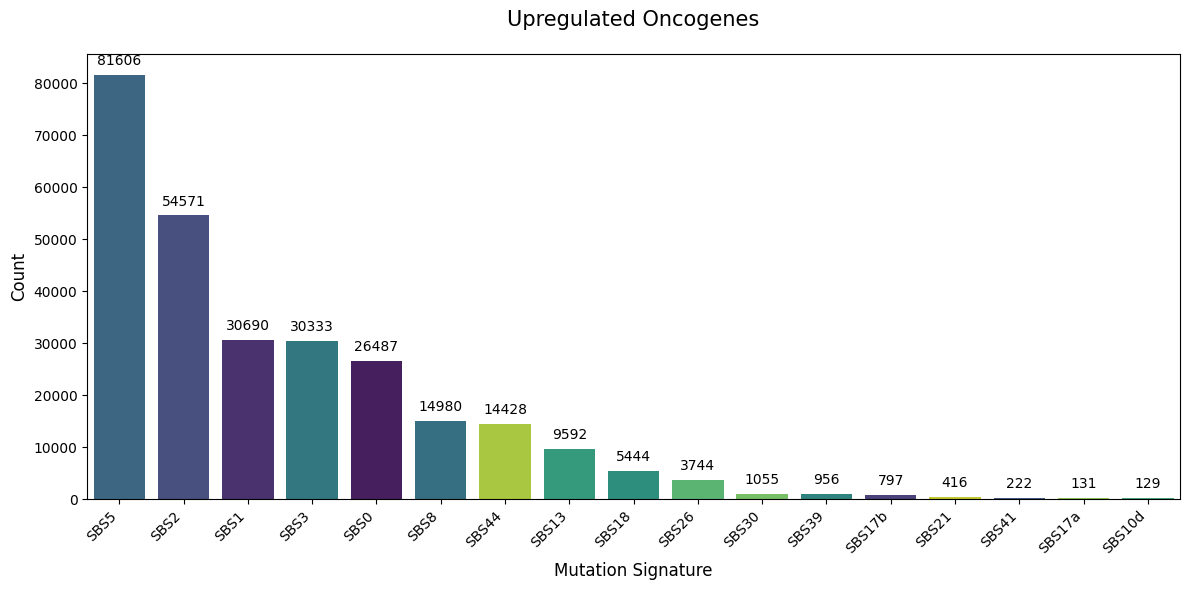

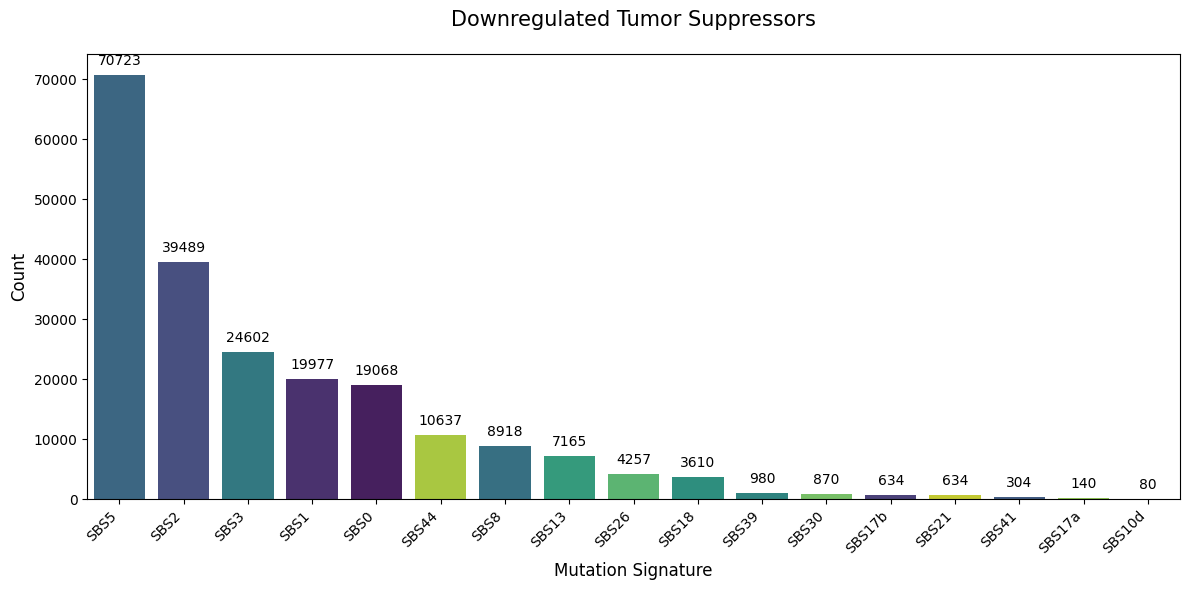

/tmp/ipykernel_3709218/855727121.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsupps['gene_type'] = 'Tumor Suppressors'
/tmp/ipykernel_3709218/855727121.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oncogenes['gene_type'] = 'Oncogenes'


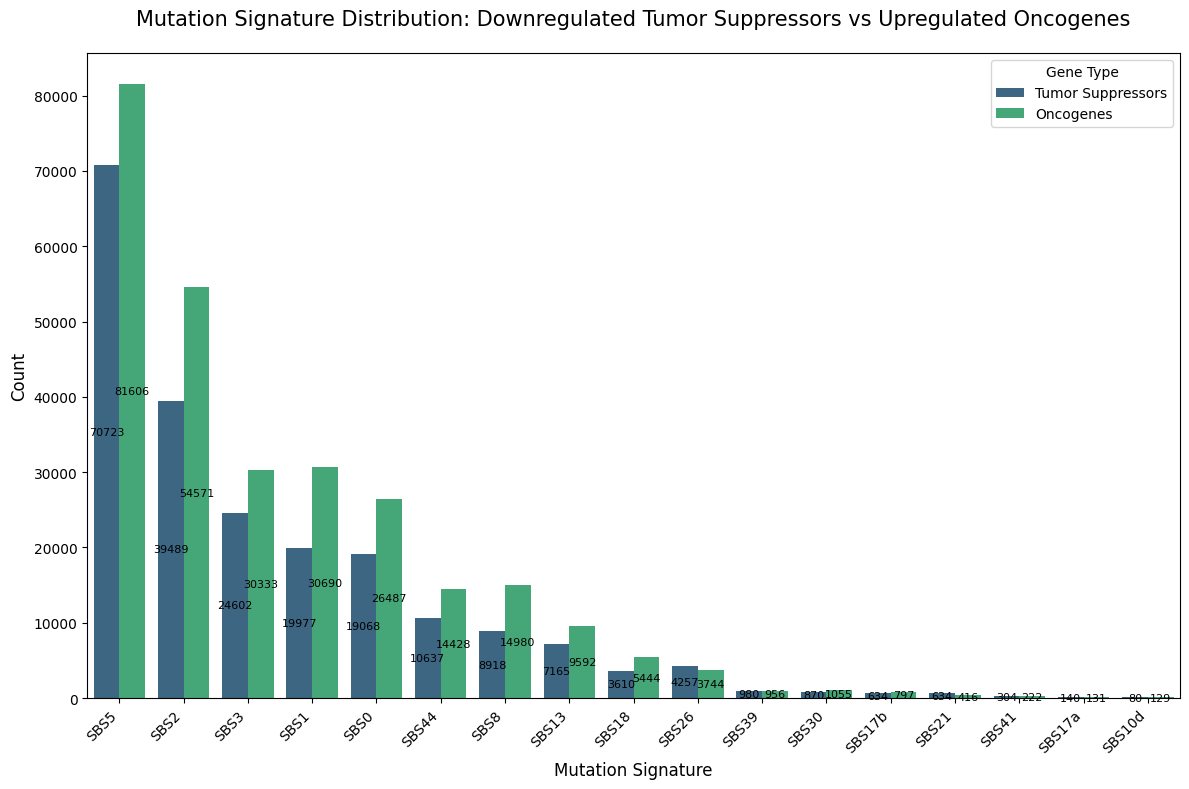

In [4]:
# Filter for significant oncogenes
df_significant_oncogenes = df_significant[df_significant['is_oncogene_consensus'] == True]
df_significant_oncogenes.head()

# Filter for upregulated significant oncogenes
df_significant_oncogenes_up = df_significant_oncogenes[df_significant_oncogenes['log2_odds_ratio'] >= 0]
oncogenes_up_ids = df_significant_oncogenes_up['gene_id'].tolist()

# Filter real dataset for upregulated oncogenes
df_real_oncogenes_up = real[real['gene_id'].isin(oncogenes_up_ids)]

df_significant_tsupps = df_significant[df_significant['is_tsupp_consensus'] == True]
df_significant_tsupps_down = df_significant_tsupps[df_significant_tsupps['log2_odds_ratio'] < 0]
tsupp_down_ids = df_significant_tsupps_down['gene_id'].tolist()
df_real_tsupps_down = real[real['gene_id'].isin(tsupp_down_ids)]

plot_mutation_signatures(df_real_oncogenes_up, title="Upregulated Oncogenes")
plot_mutation_signatures(df_real_tsupps_down, title="Downregulated Tumor Suppressors")
plot_stacked_mutation_signatures(df_real_tsupps_down, df_real_oncogenes_up)


# old code

In [5]:
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

onc = df.is_oncogene_consensus == True
tsupp = df.is_tsupp_consensus == True

upreg = df.is_gene_upregulated == True
downreg = df.is_gene_upregulated == False

sign = df.is_significant == True

sign_onc_list = df[onc & sign]['gene_id'].tolist()
sign_tsupp_list = df[tsupp & sign]['gene_id'].tolist()

sign_upreg_list = df[upreg & sign]['gene_id'].tolist()
sign_downreg_list = df[downreg & sign]['gene_id'].tolist()

# Create sets for significantly up/down regulated oncogenes and tumor suppressors
up_onc = set(sign_onc_list) & set(sign_upreg_list)
up_tsupp = set(sign_tsupp_list) & set(sign_upreg_list)
down_onc = set(sign_onc_list) & set(sign_downreg_list)
down_tsupp = set(sign_tsupp_list) & set(sign_downreg_list)


# Get distributions using these sets
up_onc_dist = real[real.gene_id.isin(up_onc)].mutsig.value_counts()
up_tsupp_dist = real[real.gene_id.isin(up_tsupp)].mutsig.value_counts()
down_onc_dist = real[real.gene_id.isin(down_onc)].mutsig.value_counts()
down_tsupp_dist = real[real.gene_id.isin(down_tsupp)].mutsig.value_counts()


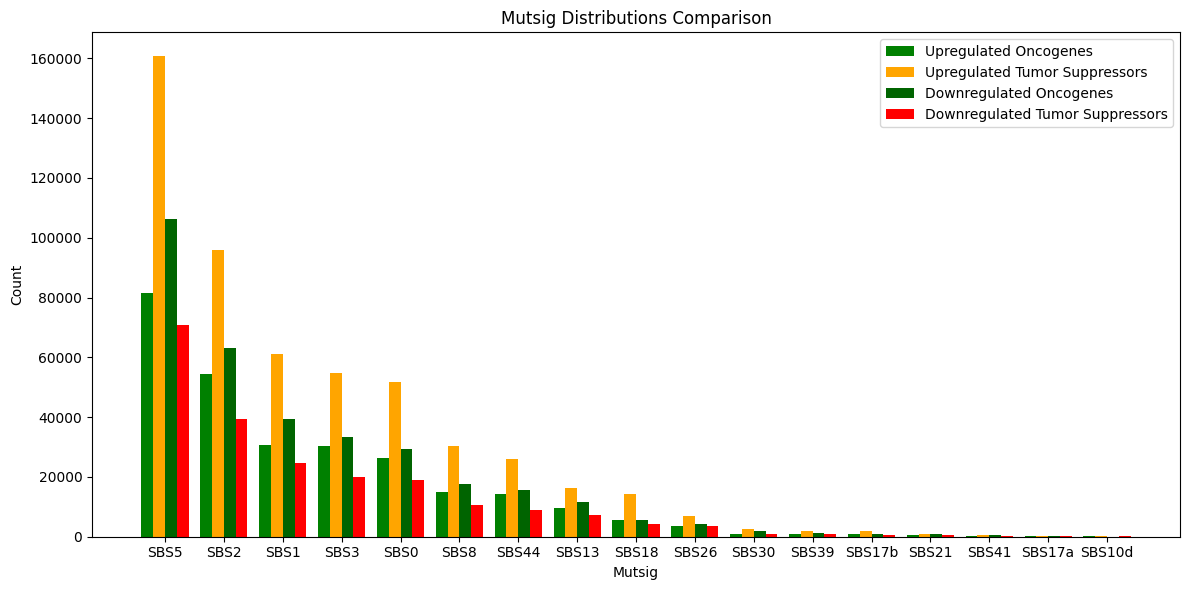

In [6]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Set width of bars and positions
bar_width = 0.2
r1 = np.arange(len(up_onc_dist))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create bars
plt.bar(r1, up_onc_dist.values, width=bar_width, label='Upregulated Oncogenes', color='green')
plt.bar(r2, up_tsupp_dist.values, width=bar_width, label='Upregulated Tumor Suppressors', color='orange')
plt.bar(r3, down_onc_dist.values, width=bar_width, label='Downregulated Oncogenes', color='darkgreen')
plt.bar(r4, down_tsupp_dist.values, width=bar_width, label='Downregulated Tumor Suppressors', color='red')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.xticks([r + bar_width*1.5 for r in range(len(up_onc_dist))], up_onc_dist.index)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

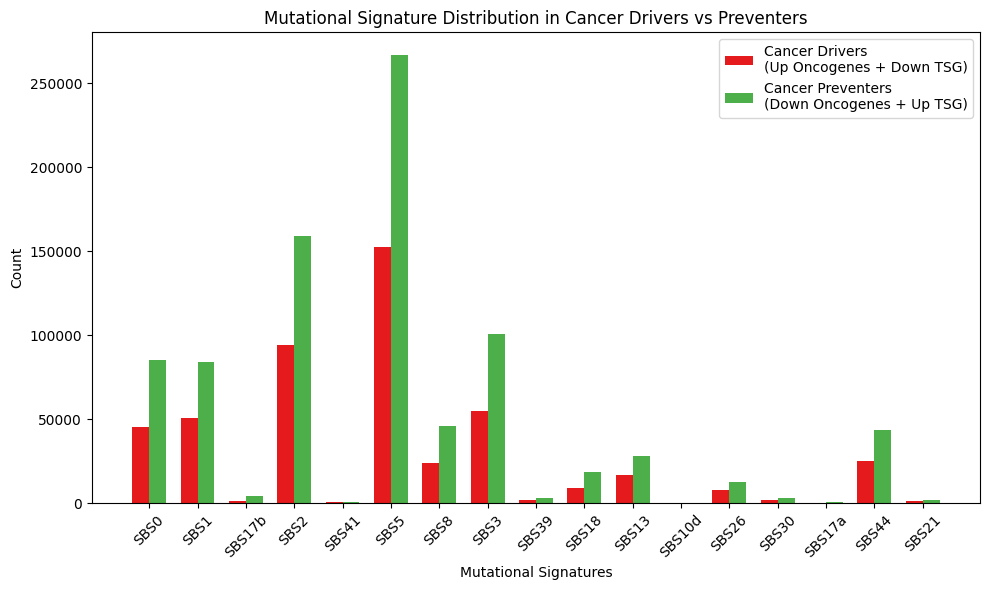

In [7]:
# Combine distributions
cancer_drivers = up_onc_dist + down_tsupp_dist  # promoting cancer
cancer_preventers = down_onc_dist + up_tsupp_dist  # preventing cancer

# Set up the plot
plt.figure(figsize=(10, 6))

# Set width of bars and positions 
bar_width = 0.35
r1 = np.arange(len(cancer_drivers))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, cancer_drivers.values, width=bar_width, label='Cancer Drivers\n(Up Oncogenes + Down TSG)', color='#e41a1c')  # Red
plt.bar(r2, cancer_preventers.values, width=bar_width, label='Cancer Preventers\n(Down Oncogenes + Up TSG)', color='#4daf4a')  # Green

# Add labels and title
plt.xlabel('Mutational Signatures')
plt.ylabel('Count')
plt.title('Mutational Signature Distribution in Cancer Drivers vs Preventers')
plt.xticks([r + bar_width/2 for r in range(len(cancer_drivers))], cancer_drivers.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


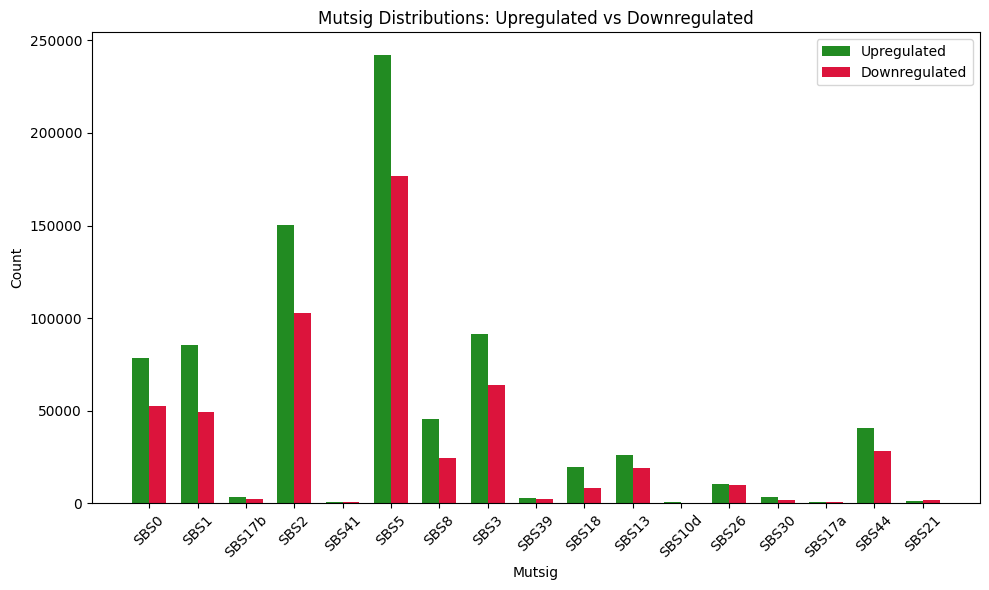

In [8]:
# Combine all upregulated (oncogenes + tsupps)
all_upreg_dist = up_onc_dist + up_tsupp_dist

# Combine all downregulated (oncogenes + tsupps)
all_downreg_dist = down_onc_dist + down_tsupp_dist

# Set up the plot
plt.figure(figsize=(10, 6))

# Set width of bars and positions 
bar_width = 0.35
r1 = np.arange(len(all_upreg_dist))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, all_upreg_dist.values, width=bar_width, label='Upregulated', color='forestgreen')
plt.bar(r2, all_downreg_dist.values, width=bar_width, label='Downregulated', color='crimson')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions: Upregulated vs Downregulated')
plt.xticks([r + bar_width/2 for r in range(len(all_upreg_dist))], all_upreg_dist.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


# known cancer drivers

In [9]:
df[(df.is_brca_driver == True) & (df.is_significant == True)].head()

,gene_id,log2_odds_ratio,p_adj,z_score,gene_name,biotype,is_significant,is_oncogene_oncokb,is_tsupp_oncokb,is_brca_driver,tier_cosmic,is_hallmark_cosmic,is_tsupp_cosmic,is_oncogene_cosmic,is_oncogene_consensus,is_tsupp_consensus,cancer_gene_role,is_gene_upregulated
13,ENSG00000104517,0.514554,3.403880e-13,0.275678,UBR5,protein_coding,True,1,0,1,1,1,0,1,1,0,oncogene,True
417,ENSG00000130396,-0.304334,1.047327e-04,-0.355290,MLLT4,protein_coding,True,0,0,1,1,0,0,1,1,0,oncogene,False
439,ENSG00000006468,0.744137,8.261283e-16,0.452575,ETV1,protein_coding,True,1,0,1,1,0,0,1,1,0,oncogene,True
902,ENSG00000196712,-0.214140,2.326150e-03,-0.285794,NF1,protein_coding,True,0,1,1,1,1,1,0,0,1,tumor_suppressor,False
947,ENSG00000171862,0.530191,7.281368e-08,0.287726,PTEN,protein_coding,True,0,1,1,1,1,1,0,0,1,tumor_suppressor,True


In [10]:
sign_brca_drivers = df[(df.is_brca_driver == True) & (df.is_significant == True)].gene_id.tolist()
sign_drivers_df = df[df.gene_id.isin(sign_brca_drivers)]

sign_oncogene_drivers = sign_drivers_df[(sign_drivers_df.cancer_gene_role == "oncogene") & (sign_drivers_df.is_significant == True)]
sign_tsupp_drivers = sign_drivers_df[(sign_drivers_df.cancer_gene_role == "tumor_suppressor") & (sign_drivers_df.is_significant == True)]
sign_dual_role = sign_drivers_df[(sign_drivers_df.cancer_gene_role == "dual_role") & (sign_drivers_df.is_significant == True)]

# cancer gene role based

<Axes: xlabel='gene_name'>

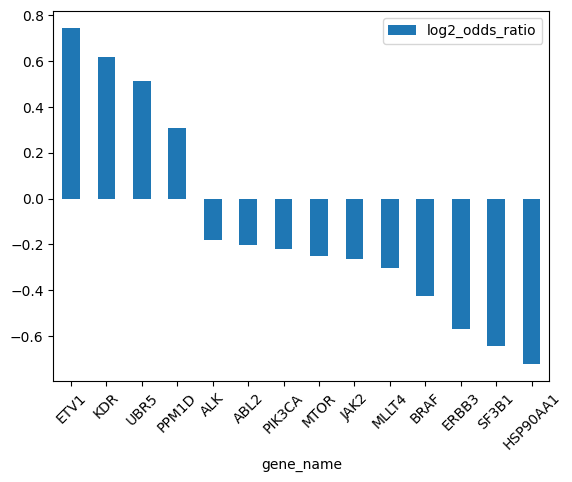

In [13]:
sign_oncogene_drivers.sort_values(by='log2_odds_ratio', ascending=False).plot.bar(x='gene_name', y='log2_odds_ratio', rot=45)

/tmp/ipykernel_3709218/167398731.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted,


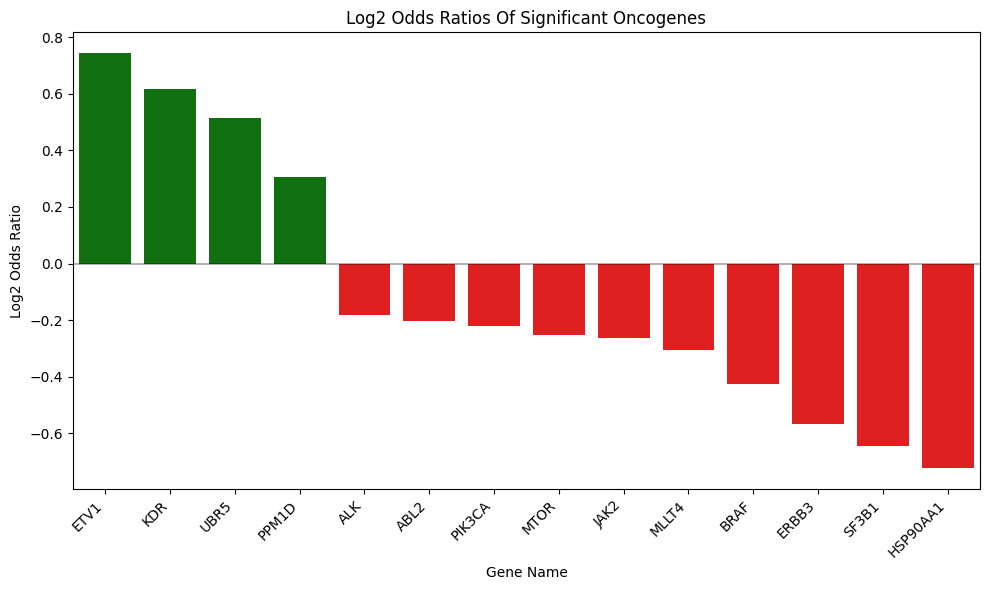

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the dataframe
df_sorted = sign_oncogene_drivers.sort_values(by='log2_odds_ratio', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted,
            x='gene_name',
            y='log2_odds_ratio',
            palette=['green' if x > 0 else 'red' for x in df_sorted['log2_odds_ratio']])

# Customize
plt.xticks(rotation=45, ha='right')
plt.xlabel('Gene Name')
plt.ylabel('Log2 Odds Ratio')
plt.title('Log2 Odds Ratios Of Significant Oncogenes')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()


/tmp/ipykernel_3709218/3007064645.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted,


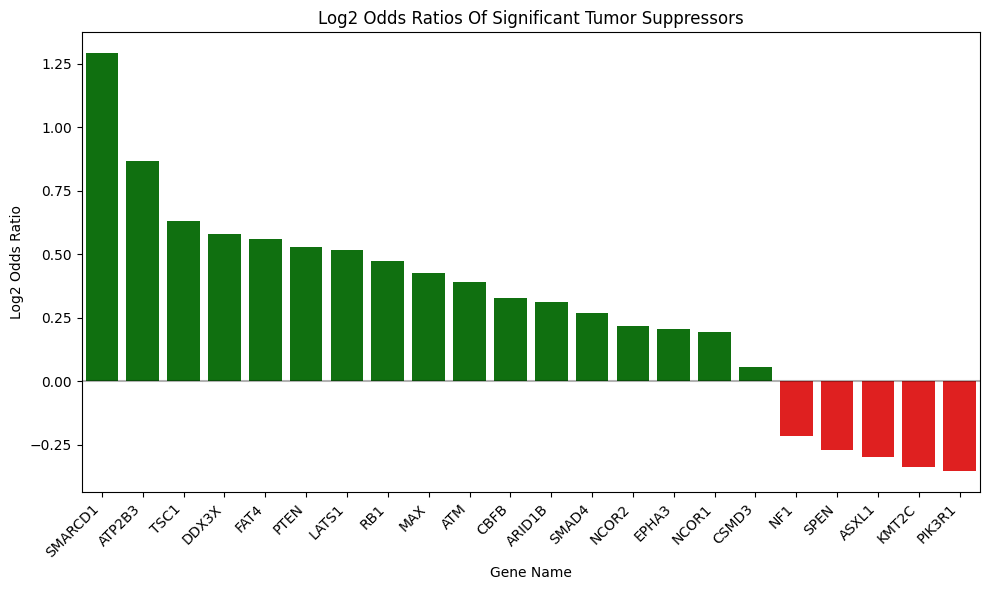

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the dataframe
df_sorted = sign_tsupp_drivers.sort_values(by='log2_odds_ratio', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted,
            x='gene_name',
            y='log2_odds_ratio',
            palette=['green' if x > 0 else 'red' for x in df_sorted['log2_odds_ratio']])

# Customize
plt.xticks(rotation=45, ha='right')
plt.xlabel('Gene Name')
plt.ylabel('Log2 Odds Ratio')
plt.title('Log2 Odds Ratios Of Significant Tumor Suppressors')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()
